## DSC170, Mini-Project # 4

This project will focus on __suitability analysis__ with raster data. Your tasks will be both conceptual-level and technical. 

There are three parts to this assignment.

1. At the conceptual level, you will define a suitability model of your choice, for an area of your choice (preferably San Diego, because we already have worked with some local data). Consult the lectures on map combination, and also see https://en.wikipedia.org/wiki/Suitability_model for a brief description of what a suitability model is. For example, you may be looking for best areas for community gardens. Such areas are often selected from underutilized land in residential land uses, with good soils, good drainage, accessible (not steep slope), etc. So you would be looking for areas with a specific type of land use/land cover, with an appropriate range of values of slope, etc. You may build additional criteria based on a range of precipitaiton values, whether the area is affected by wildfires, or has low levels of soil erosion, etc. Feel free to use the imagery layers we explored or mentioned during raster-focused lectures. One of the cells contained a list of about a dozen such layers available through AGOL - but feel free to find more. Also, feel free to download additional raster layers from elsewhere (an example in lecture demonstrates how to do this from the USGS image repository.)  You can use any __two__ of the map combination techniques discussed during lectures. You should identify the ones you use, and discuss any uncertainty issues associated with these specific map combination models. 

As the outcome of this part, you will need to: a) describe the suitability model you want to develop; b) identify the raster data layers you will use; and c) describe two of the map combination techniques you will use to derive the two suitablity maps, and their pros and cons.

2. The second part will involve implementing your suitability model using arcgis raster functions. Many of these functions are new and experimental! Examples of what works are in the lecture notebooks. Be creative! But also note that the functions are associated with raster services and depend on the version of the server a particular imagery layer is served from. See in the lecture notebooks how you can retrieve the version of the API supported by each layer, and which functions are supported in each API. 

3. The third part will be a brief write-up comparing the two output rasters generated for the suitability models using the two map combination techniques. 

The notebook should include documentation of the steps, as usually.

__How to submit.__ This MP4 template notebook can be fetched and submitted from NBGrader on the UCSD Datahub. 

In [90]:
# Names: 
# Caiwei Wang 
# IDs:
# A15262692

# 1. Formulate a suitability model (markdown, about 100 words)
San Diego Ambrosia is a rare species in the Asteraceae (Sunflower) family.  It is adapted to __dry habitat__, but only on upper floodplain fringes, or adjoining depressions containing vernal pools or similar structures. It is a plant of __open habitat__ and is __not tolerant of heavy shade__. If not given __supplemental summer water__ it will become deciduous but will come back from the rhizome after winter rain. This model is a suitability model that will help finding the best locations for restoration projects of San Diego Ambrosia.
1. low elevation : Elevation: 33" - 1960" inside this range 1, outside this range 0. 
2. closeness to watershed
3. Annual Precipitation: 9.9" - 15.0", in this range 1, outside this range 0. 
4. temperature
- Coldest Month: 46.7" - 55.4"
- Hottest Month: 71.0" - 80.4"

5. Humidity: 1.64" - 28.65

The model will use exclusinary screening. 

In [120]:
landsat_item = agol.content.search('Multispectral Landsat', 'Imagery Layer', outside_org=True)[2]
landsat = landsat_item.layers[0]

In [121]:
for rasterfunc in landsat.properties.rasterFunctionInfos:
    print(rasterfunc.name)

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
Band 10 Surface Temperature in Fahrenheit
Band 11 Surface Temperature in Fahrenheit
Band 10 Surface Temperature in Celsius
Band 11 Surface Temperature in Celsius
None


In [151]:
# 2. Imports, etc.
from arcgis import GIS
from arcgis.raster import *
from arcgis.geometry import *
%matplotlib inline
import pandas as pd
import numpy as np
gis = GIS('https://gis-portal.ucsd.edu/portal', 'caw062@ad')
agol = GIS(username="caw062_dsc170fa20", verify_cert=False) 
arcgis.raster.analytics.is_supported(gis)

Enter password: ········
Enter password: ········


True

In [147]:
# 3. List imagery layers to be used in your model. This cell should contian layer definitions.

usa_mean_rainfall = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Rainfall/ImageServer", agol)
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',agol)
usa_monthly_temperature_max= ImageryLayer("https://geo.fas.usda.gov/arcgis1/rest/services/G_Maximum_Temperature/Month/ImageServer",agol)
usa_monthly_temperature_min= ImageryLayer("https://geo.fas.usda.gov/arcgis1/rest/services/G_Mininium_Temperature/Month/ImageServer",agol)
usa_mean_temperature = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer", agol)
land_types = gis.content.get('1453082255024699af55c960bc3dc1fe').layers[0]


In [ ]:
# 4. Derive the area of interest (AOI) and its geometry and extent. 
# The smaller the area the better (so that you don't run into raster size limitations)


In [96]:
from arcgis.geocoding import geocode

# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_gcd = geocode(address='San Diego County, CA', out_sr=usa_mean_rainfall.extent['spatialReference'])

# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_gcd[0]['extent']
study_area_extent

{'xmin': -1931399.6523251582,
 'ymin': -731590.9702901123,
 'xmax': -1735352.7067699027,
 'ymax': -499185.04972745664}

In [97]:
counties_item = agol.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[1]
counties_item
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

In [98]:
print(study_area_geom)
print("-----------------------------------------------")
print(study_area_extent)

{'rings': [[[-13038640.2378045, 3833847.56313313], [-13046623.4026057, 3857991.25757854], [-13037806.2894249, 3842709.77649226], [-13038242.9630011, 3852764.625192], [-13046507.9224498, 3860702.91542385], [-13052010.6888388, 3852918.36925318], [-13056142.698569, 3875572.5844261], [-13052752.1896589, 3880470.16217001], [-13060942.1288156, 3910110.69831699], [-13070037.4669952, 3926416.80993839], [-13090875.0407958, 3947789.6111035], [-13088850.2944962, 3956573.52304734], [-13083096.9145435, 3957334.95729047], [-13081091.6600256, 3960320.76148142], [-13081044.9604849, 3962992.62952016], [-13064742.9108947, 3963248.36768519], [-13065162.4628438, 3960696.59973376], [-13050808.7840634, 3954550.54729093], [-13050743.3943262, 3953033.60970995], [-13027843.751501, 3953125.99386067], [-13027782.6003613, 3952155.15750851], [-12922233.0458749, 3951969.51409108], [-12922139.2950188, 3905207.95747332], [-12924640.5058097, 3905050.31386036], [-12924969.1787687, 3844903.30316599], [-13038640.2378045,

In [99]:
map_rainfall = agol.map()
map_rainfall.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_rainfall.legend=True
map_rainfall.add_layer(rainfall_clip)
map_rainfall

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [100]:
usa_mean_rainfall.extent = study_area_extent
rainfall_clip = clip(raster=usa_mean_rainfall, geometry=study_area_geom)

rainfall_b = remap(raster=rainfall_clip,
                  input_ranges=[0.0,8,8,15,15,40],
                  output_values=[0,1,0],  astype='U8')

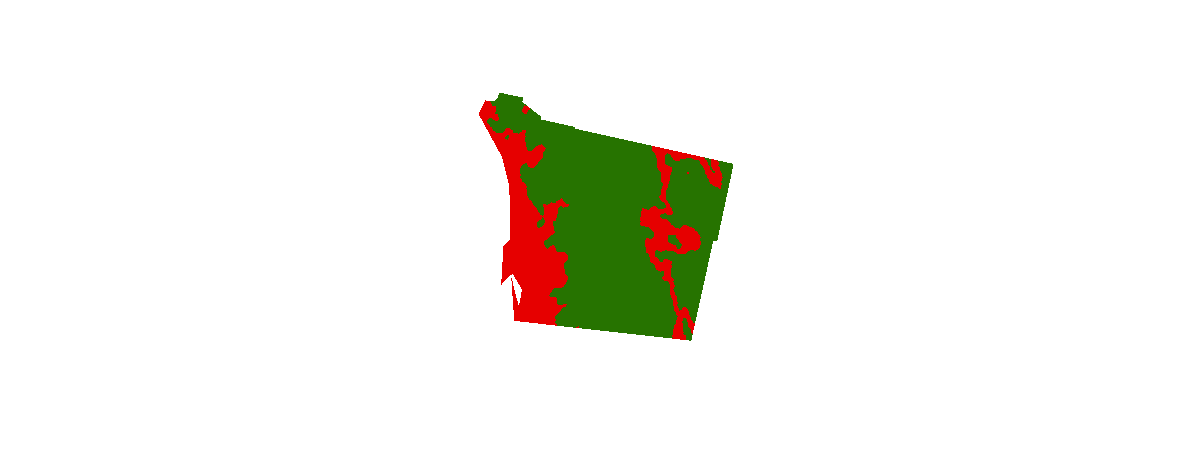

In [101]:
rainfall_b_c = colormap(rainfall_b, colormap=clrmap2)
rainfall_b_c

In [117]:
map_raindrop_b = agol.map()
map_raindrop_b.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_raindrop_b.legend=True
map_raindrop_b.add_layer(rainfall_b_c)
map_raindrop_b

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [110]:
from arcgis.geometry import *
study_area_ex = Geometry(study_area_geom).geoextent  # or just 'extent'

# then create the extent as a dict from the returned tuple 

tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

# to be correcter, let's also add CRS:
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
study_area_extent

{'xmin': -13090875.0407958,
 'ymin': 3833847.56313313,
 'xmax': -12922139.2950188,
 'ymax': 3963248.36768519,
 'spatialReference': {'latestwkid': 3857, 'wkid': 102100}}

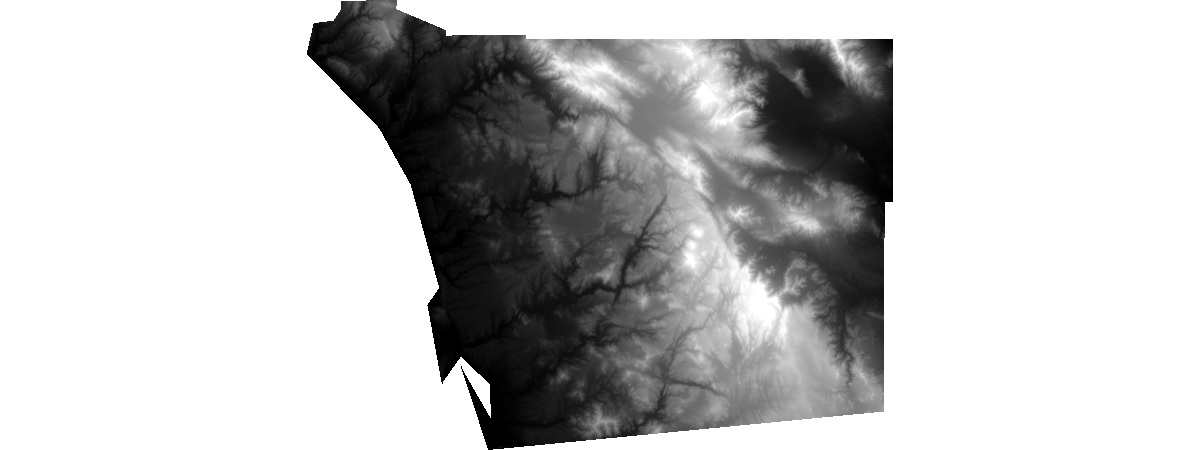

In [112]:
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',agol)
usa_elevation.extent = study_area_extent
elev_clip = clip(raster=usa_elevation, geometry=study_area_geom)
stretch(raster=elev_clip, stretch_type='StdDev', dra='true')


In [109]:
map_rainfall = agol.map()
map_rainfall.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_rainfall.legend=True
map_rainfall.add_layer(elev_clip)
map_rainfall

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [139]:
elev_n = remap(elev_clip,
                       input_ranges=[-500,33, 33,1960,1960,8900],
                       output_values=[0,1,0], astype='U8')
elev_n_c = colormap(elev_n, colormap=clrmap2)
map_elev_n = agol.map()
map_elev_n.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_elev_n.legend=True
map_elev_n.add_layer(elev_n_c)
map_elev_n

MapView(layout=Layout(height='400px', width='100%'), legend=True)

MapView(layout=Layout(height='400px', width='100%'), legend=True)

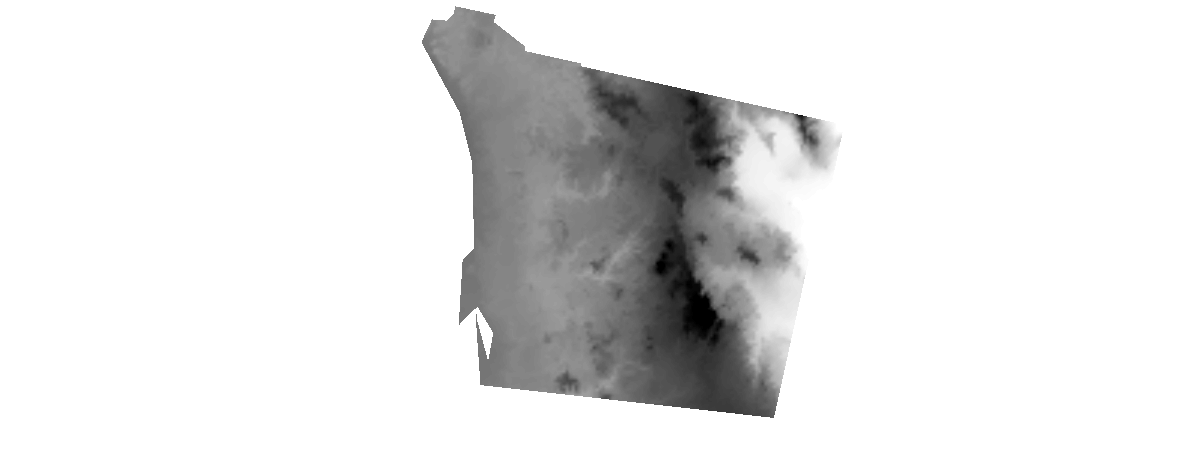

In [134]:
usa_mean_temperature.extent = study_area_extent
temp_clip = clip(raster=usa_mean_temperature, geometry=study_area_geom)
stretch(raster=temp_clip, stretch_type='StdDev', dra='true')

In [135]:
map_rainfall = agol.map()
map_rainfall.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_rainfall.legend=True
map_rainfall.add_layer(temp_clip)
map_rainfall

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [136]:
def F2C(F):
    return (F-32)*(5/9)
print(F2C(71))
print(F2C(80.4))
print(F2C(46.7))
print(F2C(55))

21.666666666666668
26.888888888888893
8.166666666666668
12.777777777777779


In [142]:
temp_b = remap(temp_clip,
                       input_ranges=[0,14.5,14.5,19.35,19.35,30],
                       output_values=[0,1,0], astype='U8')
temp_b_c = colormap(temp_b, colormap=clrmap2)
map_temp_b = agol.map()
map_temp_b.extent = {'spatialReference':{'latestwkid':3857, 'wkid':102100},
                    'xmax': -12899970.884006657,
                    'xmin': -13094557.353913298,
                    'ymax': 4016441.7785463207,
                    'ymin': 3784318.1781899934}          
map_temp_b.legend=True
map_temp_b.add_layer(temp_b_c)
map_temp_b

MapView(layout=Layout(height='400px', width='100%'), legend=True)

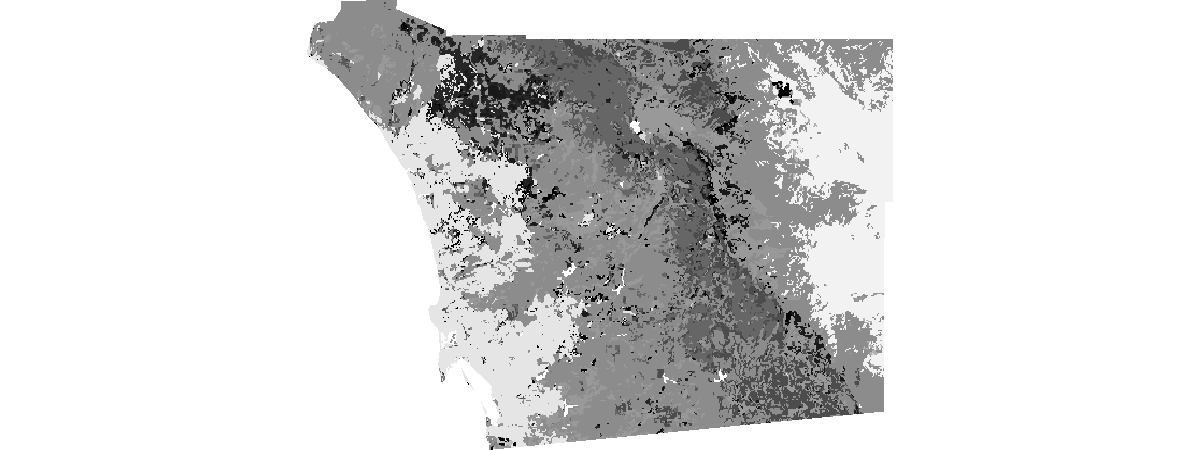

In [149]:
land_types.extent = study_area_extent
land_types_clip = clip(raster=land_types, geometry=study_area_geom)
stretch(raster=land_types_clip, stretch_type='StdDev', dra='true')

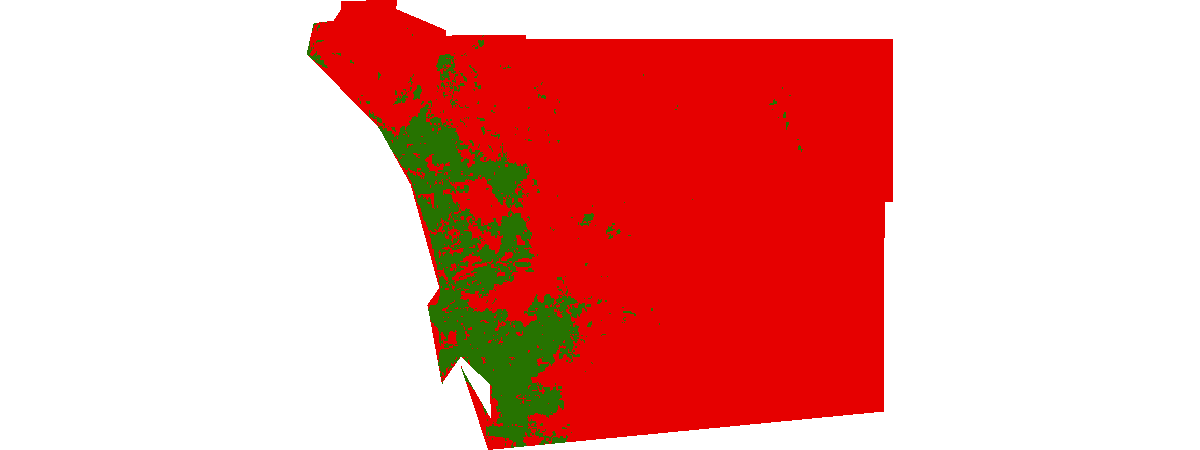

In [157]:
land_type_b = remap(land_types_clip, #190 stands for urban area, all other codes stand for non-urban areas
                       input_ranges=[0,189,190,191,191,300],
                       output_values=[1,0,1], astype='U8')
land_type_b_c = colormap(land_type_b, colormap=clrmap2)
land_type_b_c

In [ ]:
# 5. Name the two map combination techniques you will use to combine the data and describe their pros and cons (markdown) 

In [ ]:
# 6. Prepare your input layers for map combination: clip to AOI, remap/normalize, visualize the layers. Define what you mean to be on a bike route, 


In [ ]:
# 7a. Generate a composite raster layer for your first map combination technique


In [ ]:
# 7b. Generate a composite raster layer for your second map combination technique


In [ ]:
# 8. Compare the results, and describe how different combination techniques resulted in different outputs (or not.)
# 


In [ ]:
# Please let us know how much time you spent on this project, in hours: 
# (we will only examine distributions and won't look at individual responses)
assignment_timespent = 
extracredit_timespent = 